# The Problem

We will create a model based on simple artifial neural networks (ANNs) each hand image to the corresponding number the hand is depicting ($0$ to $5$).

# Data Ingest

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics
import os
import tensorflow as tf


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [3]:
def construct_dataset_file(directory):
    col_list = ['label'] + list(np.arange(128*128))
    df = pd.DataFrame({ col: pd.Series(dtype='int') for col in col_list })
    for filename in os.listdir(directory):
        file_location = os.path.join(directory, filename)
        image = tf.keras.utils.load_img(file_location, color_mode='grayscale')
        pixels = np.array(image).flatten()
        
        label = int(filename[-6])
        df.loc[len(df.index)] = np.insert(pixels, 0, label)
        
    return df

def load_train_df(forced=False):
    TRAIN_IMAGES_DIRECTORY = '/kaggle/input/fingers/train'
    TRAIN_DATASET_FILE = '/kaggle/working/train.csv'

    if not os.path.exists(TRAIN_DATASET_FILE) or forced:
        print("Constructing train dataset")
        df = construct_dataset_file(TRAIN_IMAGES_DIRECTORY)
        df.to_csv(TRAIN_DATASET_FILE, index=False)
        return df
    else:
        print("Loading cached train dataset")
        return pd.read_csv(TRAIN_DATASET_FILE)

def load_test_df(forced=False):
    TEST_IMAGES_DIRECTORY = '/kaggle/input/fingers/test'
    TEST_DATASET_FILE = '/kaggle/working/test.csv'

    if not os.path.exists(TEST_DATASET_FILE) or forced:
        print("Constructing test dataset")
        df = construct_dataset_file(TEST_IMAGES_DIRECTORY)
        df.to_csv(TEST_DATASET_FILE, index=False)
        return df
    else:
        print("Loading cached test dataset")
        return pd.read_csv(TEST_DATASET_FILE)
    
# raw_train_df = load_train_df(forced=True)
# raw_test_df = load_test_df(forced=True)
raw_train_df, raw_test_df = load_train_df(), load_test_df()

Loading cached train dataset
Loading cached test dataset


In [4]:
# Let's have a look at the raw train dataset.
raw_train_df.head()

,label,0,1,2,3,4,5,6,7,8,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,4,58,56,54,54,54,53,49,48,51,...,34,34,42,47,50,52,52,51,51,51
1,4,52,50,47,44,41,41,43,43,41,...,41,40,41,39,33,26,21,19,18,18
2,0,37,35,33,33,36,36,33,34,40,...,33,31,32,30,26,29,39,42,41,40
3,4,51,52,53,53,52,50,49,50,54,...,45,46,42,41,43,45,50,50,47,45
4,1,67,66,65,66,68,70,72,72,71,...,60,58,56,55,53,54,56,57,58,58


In [5]:
# Let's have a look at the raw test dataset.
raw_test_df.head()

,label,0,1,2,3,4,5,6,7,8,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,1,67,66,64,65,67,66,64,64,66,...,68,68,67,63,55,52,54,55,55,55
1,0,78,75,71,69,69,64,56,55,62,...,66,65,63,63,66,66,65,65,66,67
2,0,58,56,53,54,61,63,61,59,57,...,63,63,63,64,66,68,71,70,66,65
3,3,51,51,53,53,53,53,54,55,56,...,67,63,56,53,52,50,46,46,48,49
4,4,34,34,36,37,39,40,41,43,46,...,35,34,31,32,38,38,34,30,28,26


In [6]:
def split_X_y(df):
    X = df.drop(columns=['label'])
    y = df['label']
    return X, y

# Split the train dataset
X_train, y_train = split_X_y(raw_train_df)
print(f"X_train shape: {X_train.shape}")
print(f"y_train length: {len(y_train)}")

# Split the test dataset
X_test, y_test = split_X_y(raw_test_df)
print(f"X_test shape: {X_test.shape}")
print(f"y_test length: {len(y_test)}")

X_train shape: (18000, 16384)
y_train length: 18000
X_test shape: (3600, 16384)
y_test length: 3600


# Exploratory Data Analysis

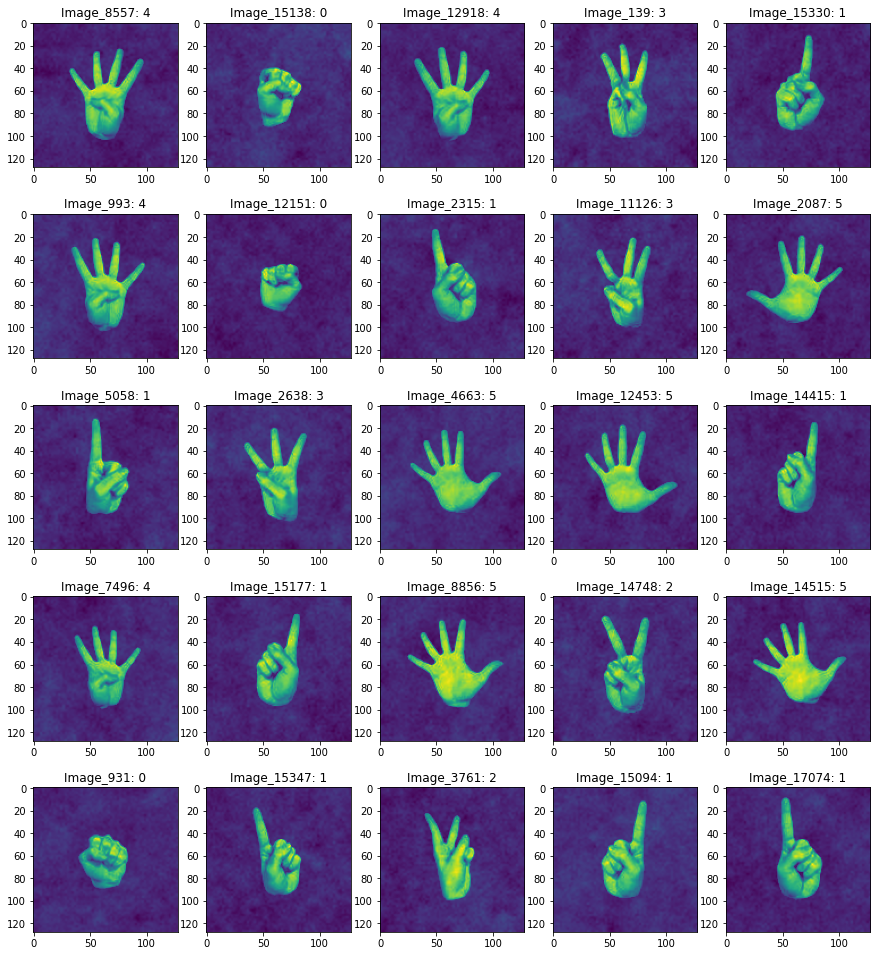

In [7]:
# Let's visualize some images from the dataset
n_rows = 5
n_cols = 5
fig = plt.figure(figsize=(15, 17))
ax = []
for i in range(1, n_rows * n_cols + 1):
    img_index = np.random.randint(len(X_train))
    image = np.reshape(X_train.loc[img_index].to_numpy(), (128, 128))
    label = y_train[img_index]
    ax.append(fig.add_subplot(n_rows, n_cols, i))
    ax[-1].set_title(f"Image_{img_index}: {label}")
    plt.imshow(image)

plt.show()

In [8]:
# Find the range of the pixels
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,58,56,54,54,54,53,49,48,51,53,...,34,34,42,47,50,52,52,51,51,51
1,52,50,47,44,41,41,43,43,41,39,...,41,40,41,39,33,26,21,19,18,18
2,37,35,33,33,36,36,33,34,40,41,...,33,31,32,30,26,29,39,42,41,40
3,51,52,53,53,52,50,49,50,54,55,...,45,46,42,41,43,45,50,50,47,45
4,67,66,65,66,68,70,72,72,71,68,...,60,58,56,55,53,54,56,57,58,58


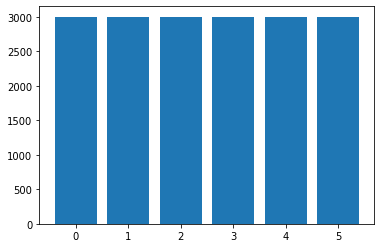

In [9]:
y_value_counts = y_train.value_counts().sort_index()
plt.bar(y_value_counts.index, y_value_counts.values)
plt.show()

    tf.keras.layers.Dense(20, activation='relu'),
# Modelling

# Baseline Modelling

We start modelling iwth a simple neural network with one hidden layer consisting of 10 Dense units. The activation function for the hidden layer shall be `relu`.

The output layer consists of `6` units, each representing the class label. The activation function would be `softmax` as this is a multi-class classification problem.

In [10]:
tf.random.set_seed(42)

model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history1 = model1.fit(X_train, y_train, epochs=20, verbose=0)

2023-01-21 06:00:30.262889: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


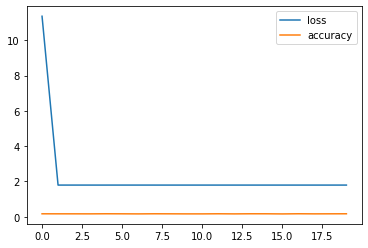

In [11]:
def plot_model_learning(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.legend()

plot_model_learning(history1)

Accuracy: 16.67%


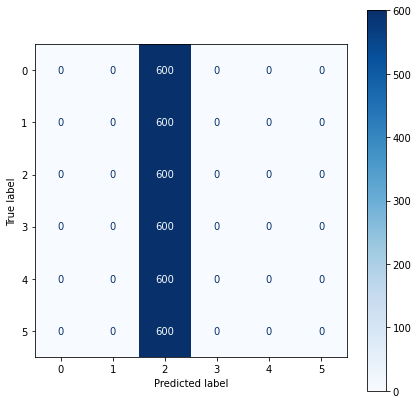

In [12]:
def evaluate_model(model, X_test, y_true):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    fig, ax = plt.subplots(figsize=(10,10))
    cm_display=sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true,y_pred,
                                                                       cmap=plt.cm.Blues,
                                                                       ax=ax)
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
evaluate_model(model1, X_test, y_test)

❗️The model is of no use as it predicts $3$ all of the time.

## Model 2 - Normalized Train Set

Neural networks like their inputs to be between $0$ and $1$ - it accelerates their learning. We use the same baseline model structure but normalize the train set before feeding into the network.

In [13]:
# Check the values of train set
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,58,56,54,54,54,53,49,48,51,53,...,34,34,42,47,50,52,52,51,51,51
1,52,50,47,44,41,41,43,43,41,39,...,41,40,41,39,33,26,21,19,18,18
2,37,35,33,33,36,36,33,34,40,41,...,33,31,32,30,26,29,39,42,41,40
3,51,52,53,53,52,50,49,50,54,55,...,45,46,42,41,43,45,50,50,47,45
4,67,66,65,66,68,70,72,72,71,68,...,60,58,56,55,53,54,56,57,58,58


In [14]:
# As the values of the pixels are grayscale, their range is 0-255
# We normalize the train set by dividing all the values by 255
X_train_norm = X_train/255.0
X_train_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.227451,0.219608,0.211765,0.211765,0.211765,0.207843,0.192157,0.188235,0.200000,0.207843,...,0.133333,0.133333,0.164706,0.184314,0.196078,0.203922,0.203922,0.200000,0.200000,0.200000
1,0.203922,0.196078,0.184314,0.172549,0.160784,0.160784,0.168627,0.168627,0.160784,0.152941,...,0.160784,0.156863,0.160784,0.152941,0.129412,0.101961,0.082353,0.074510,0.070588,0.070588
2,0.145098,0.137255,0.129412,0.129412,0.141176,0.141176,0.129412,0.133333,0.156863,0.160784,...,0.129412,0.121569,0.125490,0.117647,0.101961,0.113725,0.152941,0.164706,0.160784,0.156863
3,0.200000,0.203922,0.207843,0.207843,0.203922,0.196078,0.192157,0.196078,0.211765,0.215686,...,0.176471,0.180392,0.164706,0.160784,0.168627,0.176471,0.196078,0.196078,0.184314,0.176471
4,0.262745,0.258824,0.254902,0.258824,0.266667,0.274510,0.282353,0.282353,0.278431,0.266667,...,0.235294,0.227451,0.219608,0.215686,0.207843,0.211765,0.219608,0.223529,0.227451,0.227451


In [15]:
# Normalize X_test as well
X_test_norm = X_test/255.0
X_test_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.262745,0.258824,0.250980,0.254902,0.262745,0.258824,0.250980,0.250980,0.258824,0.250980,...,0.266667,0.266667,0.262745,0.247059,0.215686,0.203922,0.211765,0.215686,0.215686,0.215686
1,0.305882,0.294118,0.278431,0.270588,0.270588,0.250980,0.219608,0.215686,0.243137,0.250980,...,0.258824,0.254902,0.247059,0.247059,0.258824,0.258824,0.254902,0.254902,0.258824,0.262745
2,0.227451,0.219608,0.207843,0.211765,0.239216,0.247059,0.239216,0.231373,0.223529,0.215686,...,0.247059,0.247059,0.247059,0.250980,0.258824,0.266667,0.278431,0.274510,0.258824,0.254902
3,0.200000,0.200000,0.207843,0.207843,0.207843,0.207843,0.211765,0.215686,0.219608,0.211765,...,0.262745,0.247059,0.219608,0.207843,0.203922,0.196078,0.180392,0.180392,0.188235,0.192157
4,0.133333,0.133333,0.141176,0.145098,0.152941,0.156863,0.160784,0.168627,0.180392,0.176471,...,0.137255,0.133333,0.121569,0.125490,0.149020,0.149020,0.133333,0.117647,0.109804,0.101961


In [16]:
tf.random.set_seed(42)

model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax'),
])

model2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history2 = model2.fit(X_train_norm, y_train, epochs=20, verbose=0)

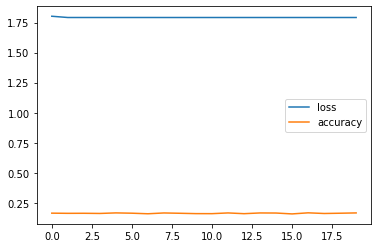

In [17]:
plot_model_learning(history2)

Accuracy: 16.67%


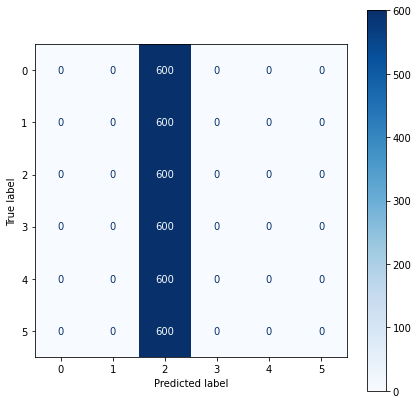

In [18]:
evaluate_model(model2, X_test_norm, y_test)

The model is way better than the baseline, thanks to normalization of the training set. However based on the confusion matri, the model recognizes $1$-hands with $0$-hands. 

## Model 3 - Additional hidden layers

In [19]:
tf.random.set_seed(42)

model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model3.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history3 = model3.fit(X_train_norm, y_train, epochs=20, verbose=0)

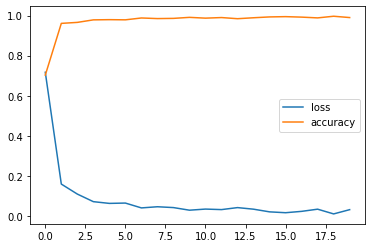

In [20]:
plot_model_learning(history3)

Accuracy: 99.72%


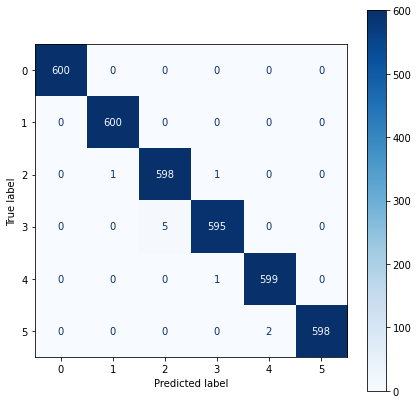

In [21]:
evaluate_model(model3, X_test_norm, y_test)

# Optional: Did normalization really helped?